In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import pandas as pd
import numpy as np
import gzip
import json
import math
from datetime import datetime
from IPython.display import display
%matplotlib inline

from rl_framework import *
from manage_orderbooks import *
from orderbook_trade_simulator import *

# Neural Network
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
filename = '../data/snapshots/orderbooks_USDT_BTC_range1.15_samplesNone_snapshot2017-01-11T17:18.dict'
currency_pair = 'USDT_BTC'
offset = 0
orderbooks, timestamps = load_orderbook_snapshot(infile=filename, first_line=offset+0, last_line=offset+100)
# display(timestamps)
print(len(orderbooks), len(timestamps), len(orderbooks[0]))
# orderbooks = orderbooks[:1000]

100%|██████████| 100/100 [00:01<00:00, 73.71it/s]

Loaded Orderbooks: 100
(100, 100, 908)


In [3]:
V = 40  # trading volume
T = 10  # Time horizon: 10 -> periods -> P*10 minutes
P = 2  # period length
episodes = 3

,Amount,Price,Type
992,0.419626,702.680000,bid
993,3.637036,703.010000,bid
994,0.549537,703.230000,bid
995,0.000000,704.703971,center
996,4.398300,706.180000,ask
997,0.508136,706.190000,ask
998,2.870490,706.450000,ask


/usr/lib64/python2.7/site-packages/pandas/core/indexing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


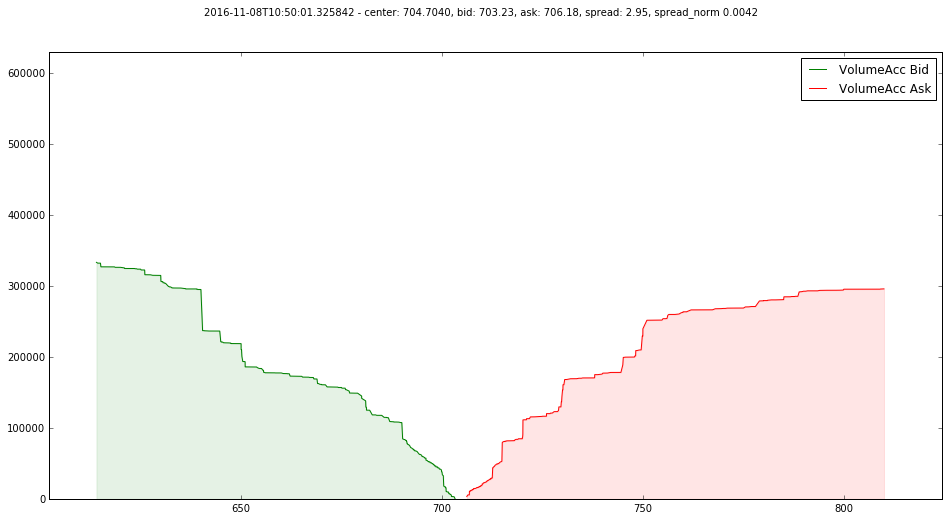

In [4]:
episode_windows = []
for e in range(1,episodes):
    window = {'orderbooks': [orderbooks[e*T*P + idx].copy() for idx in range(T*P)],
              'timestamps': [timestamps[e*T*P + idx] for idx in range(T*P)]}
    episode_windows.append(window)
# display(orderbook_preview(orderbooks[0], 3))
# display(orderbook_preview(orderbooks[1], 3))
# display(orderbook_preview(orderbooks_episodes[0][1], 3))

df = orderbooks[-50]
display(orderbook_preview(df, 3))

plot_orderbook(df, timestamps[-50], range_factor=1.17)

In [5]:
STATE_DIM = 2
actions = [-2, -1, 0, 1, 2]
NUM_ACTIONS = len(actions)

In [6]:
def base_model():
    model = Sequential()
    model.add(Dense(164, input_dim=STATE_DIM, activation='relu'))
    model.add(Dense(32, activation='relu'))
    # model.add(Dense(32, activation='relu'))
    # model.add(Dense(64, activation='relu'))
    # model.add(Dense(32, activation='relu'))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(NUM_ACTIONS, activation='linear'))
    model.compile(loss='mse', optimizer='Adam')
    return model

model = base_model()

In [7]:
max_steps = T
epochs = 2
gamma = 0.9

MAX_EXPLORATION_RATE = 1.
MIN_EXPLORATION_RATE = 0.05
DECAY_RATE = 0.005
epsilon = 1

bufferSize = 3
batchSize = 3
replay = Memory(bufferSize)
output = Memory(5)
# stores tuples of (S, A, R, S')

# acc_reward = 0
for i_episode in range(epochs):
    obs = episode_windows[i_episode]['orderbooks']
    timestamps = episode_windows[i_episode]['timestamps']

    ots = OrderbookTradingSimulator()
    
    volume = V
    time_left = T
    must_trade = False
    
    state = np.array([volume, time_left])
    
    # state = discretize_state(state)
    
    acc_reward = 0
    for step in tqdm(range(max_steps)):
        qval = model.predict(state.reshape(1, STATE_DIM))
            
        if random.random() < epsilon:
            # choose random action
            action = random.choice(actions)
        else:
            # choose best action from Q(s,a) values
            action = np.argmax(qval)
            
        ob = obs[step*P]
        # display(orderbook_preview(ob, 5))
        # display(orderbook_statistics(ob, currency_pair, timestamps[step*P]))
        
        ask = get_ask(ob)
        lim = ask + action
            
            
        if step == max_steps-1:
            must_trade = True

        new_ob = ots.trade_timespan(obs[step*P:(step+1)*P],
                                timestamps[step*P],
                                timespan=P, must_trade=must_trade,
                                volume=volume, limit=lim, verbose=False)
        
        volume = ots.history.volume_left.values[-1]
        time_left -= 1
        new_state = np.array([volume, time_left])
        reward = ots.history.cost.values[-1]
        
        acc_reward += reward
        
        replay.add((state, action, reward, new_state))
        if (replay.size() >= bufferSize):
            # wait for buffer to be filled, before getting started with training
            minibatch = replay.get_random_samples(batchSize)           
            
            X_train = []
            y_train = []
            for memory in minibatch:
                state_m, action_m, reward_m, new_state_m = memory
                
                qval_old = model.predict(state_m.reshape(1, STATE_DIM))               
                y = np.zeros((1, NUM_ACTIONS))
                y[:] = qval_old[:]
                
                qval_new_m = model.predict(new_state_m.reshape(1, STATE_DIM), batch_size=1)
                maxQ = np.max(qval_new_m)
                
                update = reward_m + (gamma*maxQ)
                y[0][action_m] = update  # target output
                
                X_train.append(state_m.reshape(STATE_DIM,))
                y_train.append(y.reshape(NUM_ACTIONS,))
            X_train = np.array(X_train)
            y_train = np.array(y_train)
                        
            # print("Game #: %s" % (i_episode,))
            model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)
        state = new_state
        if volume == 0:
            break
       
    # reduce exploration rate
    if epsilon > MIN_EXPLORATION_RATE:
        epsilon = MAX_EXPLORATION_RATE *   math.exp(- DECAY_RATE * i_episode)
    info = "{:4d}/{}: epsilon={:5.3f}, reward_acc: {:0.5f}, last_reward {}, steps: {}"\
            .format(i_episode, epochs, epsilon,  acc_reward, reward, step)
    # output.add(info)
    # clear_output(wait=True)    
    # for x in output.content:
    #     print(x)
    print(info)
    # if epsilon > 0:
    #     epsilon -= (1.5/epochs)
        

 20%|██        | 2/10 [00:01<00:04,  1.74it/s]/usr/lib64/python2.7/site-packages/pandas/core/generic.py:5128: RuntimeWarning: invalid value encountered in absolute
  return np.abs(self)
 80%|████████  | 8/10 [00:05<00:01,  1.53it/s]

No shares left at t=0, Done!



  0%|          | 0/10 [00:00<?, ?it/s]

   0/2: epsilon=1.000, reward_acc: 75.35370, last_reward 16.3313480433, steps: 8


 50%|█████     | 5/10 [00:03<00:03,  1.48it/s]

No shares left at t=1, Done!
   1/2: epsilon=0.995, reward_acc: 71.55438, last_reward 15.730125084, steps: 5
